# DSW Export for ACCESS-OM2-01

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import gsw

import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath

import netCDF4 as nc
import xarray as xr
import numpy as np

from matplotlib import gridspec
from collections import OrderedDict

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41825/status,
Dashboard: /proxy/41825/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44359,Workers: 0
Dashboard: /proxy/41825/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42861,Total threads: 1
Dashboard: /proxy/43047/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35317,


### Importing the data

In [4]:
#Importing data
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
# Contour mask
isobath_depth = 1000
outfile = '/g/data/x77/cy8964/Post_Process/access-om2'+'/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
contour_mask = np.load(outfile)

In [6]:
lat_slice = slice(-90,-59)

In [7]:
# Time variant variables
def preprocess(ds):
    ds = ds[['u','age_global','salt','temp']] # Picking out variables to get both u and t grids
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
cont = cont.sel(time=slice('1900-01-01','1919-12-31'))
melt = melt.sel(time=slice('1900-01-01','1919-12-31'))

In [9]:
# Load grid variables
yt_ocean = cont['yt_ocean'].sel(yt_ocean=lat_slice)
yu_ocean = cont['yu_ocean'].sel(yu_ocean=lat_slice)
xt_ocean = cont['xt_ocean']
xu_ocean = cont['xu_ocean']
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht'].sel(yt_ocean=lat_slice)

In [10]:
mask_y_transport = contour_mask['mask_y_transport']
mask_x_transport = contour_mask['mask_x_transport']
mask_y_transport_numbered = contour_mask['mask_y_transport_numbered']
mask_x_transport_numbered = contour_mask['mask_x_transport_numbered']

In [11]:
# select out bottom values:
start_time = '1910-01-01'
end_time = '1919-12-31'
time_slice = slice(start_time,end_time)

In [12]:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

### Make nicer y axis than `contour_index` by loading in lon/lat/distance of contour

In [13]:
mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

In [14]:
mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

In [15]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

In [16]:
# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [17]:
distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [18]:
distance_along_contour

<xarray.DataArray 'distance_along_contour' (distance_along_contour: 6002)> Size: 48kB
array([4.521276e-03, 9.042552e-03, 1.230223e-02, ..., 2.100383e+01,
       2.100709e+01, 2.101035e+01])
Coordinates:
  * distance_along_contour  (distance_along_contour) float64 48kB 0.004521 .....

In [19]:
#determine where to put lon tick marks
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1

### Save transport individual files together (time mean)
This section saves data as netcdfs to improve loading speed.

(SKIP THIS SECTION IF ALREADY COMPLETE)

In [20]:
#get time data
salt = cont['salt']
salt = salt.sel(time = slice('1910-01-01','1919-12-31'))
time_data = salt.time

In [21]:
def load_monthly_data (name):
    ## load monthly saved transports as a time series

    test = xr.open_mfdataset('/g/data/x77/kc5856/sofia-cross_slope_transport/'+name+
                             '/Antarctic_cross_slope/vol_trans_across_contour_1910_01.nc').vol_trans_across_contour_binned
    vol_trans_across_contour_t = xr.zeros_like(test)
    vol_trans_across_contour_t  = vol_trans_across_contour_t.expand_dims({"time":time_data})
    count_days = 0
    # load 10 year (10 years x 12 months)
    for j in np.arange(1910,1920):
        for i in np.arange(1,13):
            it = xr.open_mfdataset('/g/data/x77/kc5856/sofia-cross_slope_transport/'+name+
                                   '/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
            it.load()
            index = (j - 1910) * 12 + (i - 1)
            vol_trans_across_contour_t[index,:,:] = it.vol_trans_across_contour_binned 
            count_days = count_days + it.ndays.values
        print(j)
    return vol_trans_across_contour_t, count_days

In [22]:
control_name = '01deg_jra55v13_ryf9091_21mbath' 
melt_name = '01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest'

In [23]:
control_vol_trans, ndays = load_monthly_data(control_name)
print(ndays)
melt_vol_trans, ndays = load_monthly_data(melt_name)
print(ndays)

1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
3650
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
3650


In [24]:
#10 year time average
def av_10yr (array):
    array_10yr = (array*array.time.dt.days_in_month).sum('time') * \
                        1/(array.time.dt.days_in_month).sum('time')
    return array_10yr
def av_last_5yr (array):
    array = array.sel(time = slice('1915-01-01','1919-12-31'))
    array_last_5yr = (array*array.time.dt.days_in_month).sum('time') * \
                        1/(array.time.dt.days_in_month).sum('time')
    return array_last_5yr
def av_last_3yr (array):
    array = array.sel(time = slice('1917-01-01','1919-12-31'))
    array_last_3yr = (array*array.time.dt.days_in_month).sum('time') * \
                        1/(array.time.dt.days_in_month).sum('time')
    return array_last_3yr
def yrly (array):
    array_yrly = (array*array.time.dt.days_in_month).groupby('time.year').sum('time') * \
                        1/(array.time.dt.days_in_month).groupby('time.year').sum('time')
    return array_yrly

In [25]:
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'
for i in np.arange(1): 
    transport_arr = [melt_vol_trans, control_vol_trans][i]
    name = [melt_name, control_name][i]
    average_transport = av_last_5yr(transport_arr)
    average_transport.load()
    ds = xr.Dataset({'vol_trans_across_contour_binned_last_5yr': average_transport})
    ds.to_netcdf(save_dir+name+'_vol_trans_across_contour_binned_last_5yr.nc')

### Transport cumulative sums for different density classes and sectors

In [20]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
# WAW = -150
# WAE = -65
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

In [21]:
# Find corresponding contour indices for sectors
basin_indices = np.zeros(7)
for i in np.arange(100,len(lon_along_contour.values)):
    if (basin_indices[1]==0):
        if (lon_along_contour.values[i]>AdelieE):
            basin_indices[1] = lon_along_contour.contour_index.values[i]
    if (basin_indices[2]==0):
        if (lon_along_contour.values[i]>RossE):
            basin_indices[2] = lon_along_contour.contour_index.values[i]
    if (basin_indices[3]==0):
        if (lon_along_contour.values[i]>AmE):
            basin_indices[3] = lon_along_contour.contour_index.values[i]
    if (basin_indices[4]==0):
        if (lon_along_contour.values[i]>BeE):
            basin_indices[4] = lon_along_contour.contour_index.values[i]
    if (basin_indices[5]==0):
        if lon_along_contour.values[i]>WeddellE:
            basin_indices[5] = lon_along_contour.contour_index.values[i]
    if (basin_indices[6]==0):
        if (lon_along_contour.values[i]>PrydzE):
            basin_indices[6] = lon_along_contour.contour_index.values[i]
basin_indices

array([   0., 1270., 2149., 2803., 3338., 4798.,    0.])

In [22]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
Am = slice(basin_indices[2],basin_indices[3])
Be = slice(basin_indices[3],basin_indices[4])
Weddell = slice(basin_indices[4], basin_indices[5])
Prydz = slice(basin_indices[5],6002)

### Plotting

In [23]:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [24]:
# Define paths
grid_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output040/ocean/ocean_grid.nc'
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'
control_nc = save_dir + 'control_vol_trans_across_contour_binned_last_5yr.nc'
melt_nc = save_dir + 'meltwater_vol_trans_across_contour_binned_last_5yr.nc'

# Load grid
grid = xr.open_dataset(grid_path)
ht = grid['ht'].sel(yt_ocean=lat_slice)
yt_ocean = grid['yt_ocean'].sel(yt_ocean=lat_slice)
xt_ocean = grid['xt_ocean']

# Load transport data
control_array = xr.open_dataset(control_nc)['vol_trans_across_contour_binned_last_5yr']
melt_array = xr.open_dataset(melt_nc)['vol_trans_across_contour_binned_last_5yr']


In [25]:
# Plotting config
colors = {'Control': '#000000', 'Melt': '#BB5566'}
linestyles = {'Control': '-', 'Melt': '--'}
linewidths = {'Control': 3, 'Melt': 2}
labels = {'Control': 'Control', 'Melt': 'Meltwater'}

Back to plotting:

0
Circumpolar 1027.7099999999998
Circumpolar 1027.6799999999998
1
Adelie 1027.6799999999998
Adelie 1027.7099999999998
2
Ross 1027.7999999999997
Ross 1027.7999999999997
3
Amundsen 1027.55
Amundsen 1027.5
4
Bellingshausen 1027.8299999999997
Bellingshausen 1027.8199999999997
5
Weddell 1027.7099999999998
Weddell 1027.6899999999998
6
Prydz 1027.5
Prydz 1027.299999999997


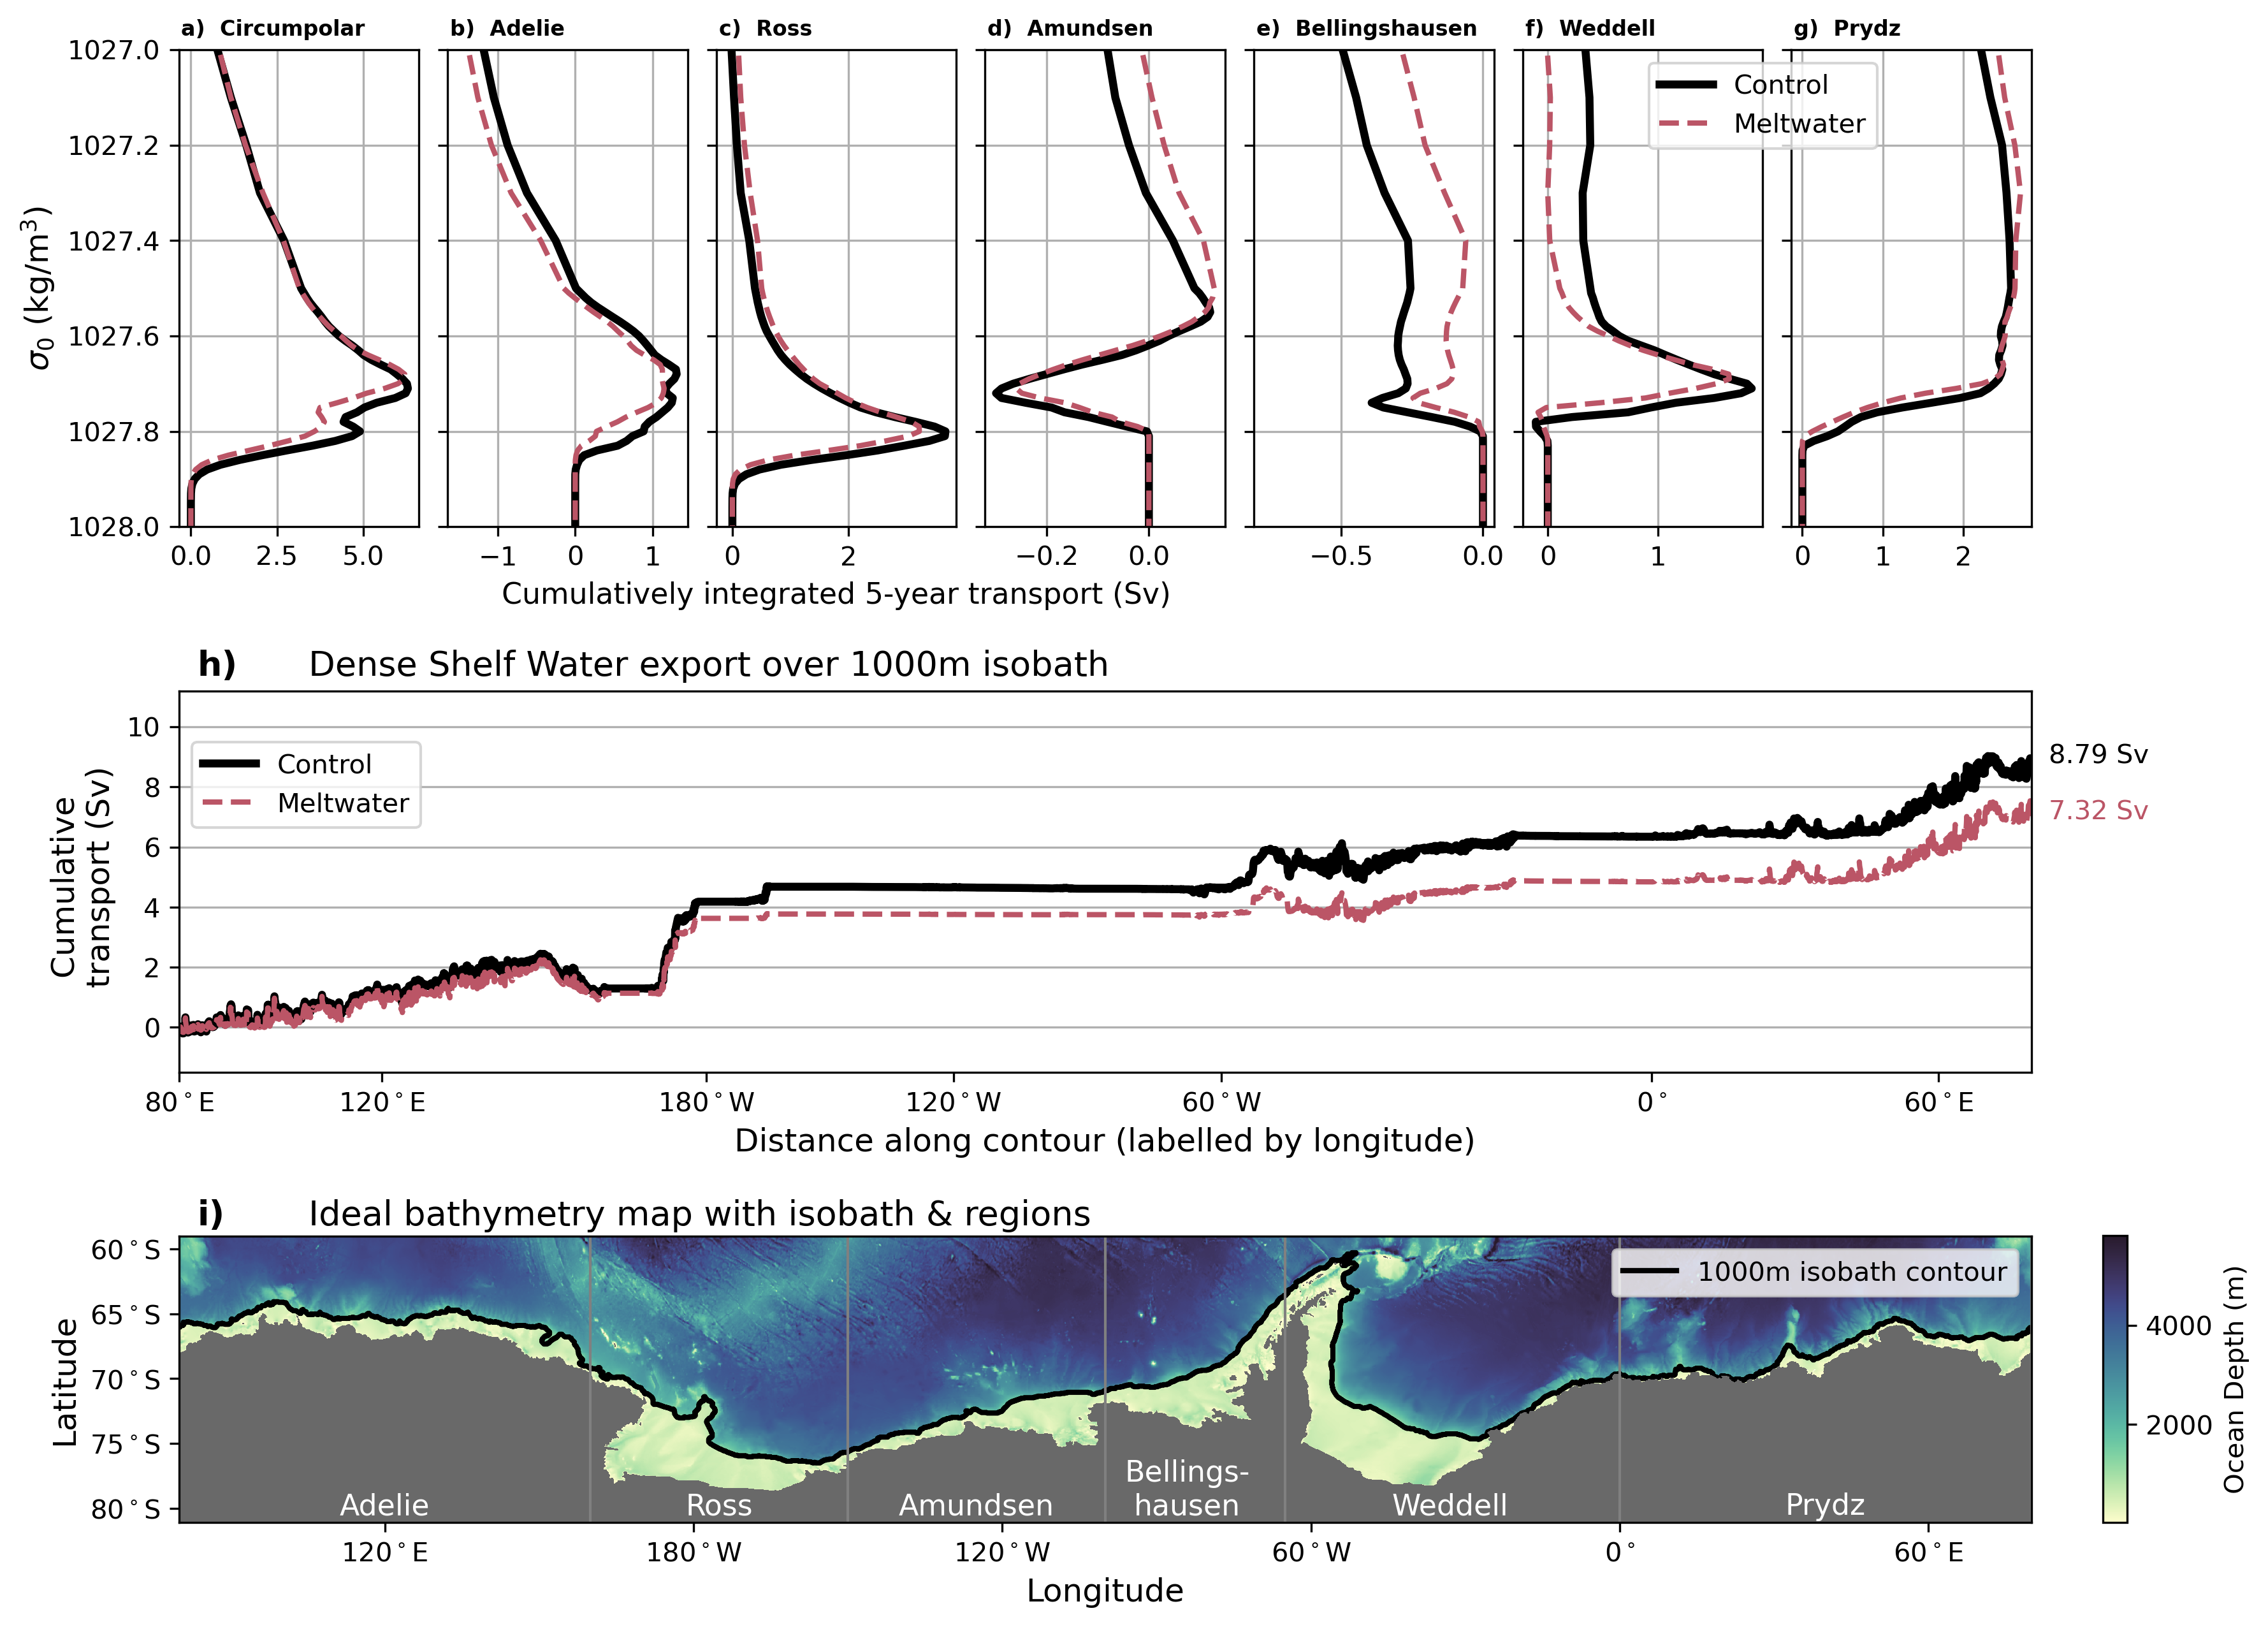

In [28]:
# Define figure and subplots like the reference style
gs = gridspec.GridSpec(3, 7, height_ratios=[1, 0.8, 0.6])
fig = plt.figure(figsize=(12.5, 10), dpi=300)
ax0, ax1, ax2, ax3, ax4, ax4b, ax5, ax6, ax7 = (
    plt.subplot(gs[2, :]), plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[0, 2]),
    plt.subplot(gs[0, 3]), plt.subplot(gs[0, 4]), plt.subplot(gs[0, 5]), plt.subplot(gs[0, 6]),
    plt.subplot(gs[1, :])
)

# Plot bathymetry in ax0
h_plot = ht.plot(ax=ax0, cmap=cm.cm.deep, add_colorbar=False)
cax = plt.axes([0.93, 0.11, 0.01, 0.15])
plt.colorbar(h_plot, cax=cax, label='Ocean Depth (m)')

ax0.contour(xt_ocean, yt_ocean, np.abs(mask_x_transport.values) + np.abs(mask_y_transport.values), colors='k')
ax0.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)

# Optional: Add vlines and region labels
ax0.vlines([-280, -200, -150, -100, -65, 0, 80], -82, -58, color='grey', linewidth=1)

region_labels = ['Adelie', 'Ross', 'Amundsen', 'Bellings-\nhausen', 'Weddell', 'Prydz']
region_lons = [-240, -175, -125, -84, -33, 40]
for x, name in zip(region_lons, region_labels):
    ax0.text(x, -81, name, ha='center', va='bottom', fontsize=11, color='w')

# Legend, labels, title
ax0.plot([0, 1], [0, 1], color='k', linewidth=2, label='1000m isobath contour')  # fake for legend
ax0.legend(loc='upper right')
ax0.set_ylabel('Latitude', fontsize=12)
ax0.set_xlabel('Longitude', fontsize=12)
ax0.set_ylim(min(yt_ocean.values), max(yt_ocean.values))
ax0.set_xticks([-240, -180, -120, -60, 0, 60])
ax0.set_xticklabels(('120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax0.set_yticks([-80, -75, -70, -65, -60])
ax0.set_yticklabels(('80$^\circ$S', '75$^\circ$S', '70$^\circ$S', '65$^\circ$S', '60$^\circ$S'))
ax0.text(0.01, 1.04, 'i)', fontsize=13, fontweight='bold', transform=ax0.transAxes)
ax0.text(0.07, 1.04, 'Ideal bathymetry map with isobath & regions', fontsize=13, transform=ax0.transAxes)

# Plot sector-wise transport profiles
axes = [ax1, ax2, ax3, ax4, ax4b, ax5, ax6]
sectors = [slice(0, 6002), Adelie, Ross, Am, Be, Weddell, Prydz]
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Amundsen', 'Bellingshausen', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']

for n, (ax, sector, name, letter) in enumerate(zip(axes, sectors, sector_names, letter_labels)):
    print(n)
    for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
        b = (array / 1e6).sel(contour_index=sector).sum('contour_index')
        transport_profile = (b.sum('isopycnal_bins') - b.cumsum('isopycnal_bins'))
        transport_profile.plot(ax=ax, y='isopycnal_bins',
                               label=labels[key], color=colors[key],
                               linestyle=linestyles[key], linewidth=linewidths[key])
        print(sector_names[n], (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').values)

    ax.set_ylim(1028.0, 1027)
    ax.grid()
    ax.set_title('')
    ax.text(0.01, 1.03, f'{letter}  {name}', transform=ax.transAxes, fontsize=8, fontweight='bold')
    if n == 0:
        ax.set_ylabel('$\sigma_0$ (kg/m$^3$)', fontsize=12)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if n == 2:
        ax.set_xlabel('Cumulatively integrated 5-year transport (Sv)', fontsize=11)
    else:
        ax.set_xlabel('')
    if n == 6:
        ax.legend(loc='upper left', bbox_to_anchor=(-0.65, 1), fontsize=10)

# Cumulative transport in ax7
slices = {
    'Ade': slice(1027.69, 1030),
    'Ros': slice(1027.82, 1030),
    'AmBe': slice(1027.79, 1030),
    'We': slice(1027.72, 1030),
    'Pr': slice(1027.65, 1030),
}

for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
    offset = 0 if key == 'Control' else -0.4
    array_copy = xr.zeros_like(array.isel(isopycnal_bins=0))

    for j in range(len(array_copy)):
        if j <= 1270:
            array_copy[j] = array.sel(isopycnal_bins=slices['Ade']).sum('isopycnal_bins').values[j] / 1e6
        elif j <= 2149:
            array_copy[j] = array.sel(isopycnal_bins=slices['Ros']).sum('isopycnal_bins').values[j] / 1e6
        elif j <= 3338:
            array_copy[j] = array.sel(isopycnal_bins=slices['AmBe']).sum('isopycnal_bins').values[j] / 1e6
        elif j <= 4798:
            array_copy[j] = array.sel(isopycnal_bins=slices['We']).sum('isopycnal_bins').values[j] / 1e6
        else:
            array_copy[j] = array.sel(isopycnal_bins=slices['Pr']).sum('isopycnal_bins').values[j] / 1e6

    cumsum = array_copy.cumsum('contour_index')
    ax7.plot(distance_along_contour, cumsum, label=labels[key],
             color=colors[key], linestyle=linestyles[key], linewidth=linewidths[key])
    ax7.text(distance_along_contour[-1] + 0.2, offset + cumsum[-1],
             f"{cumsum[-1].values:.2f} Sv", color=colors[key], fontsize=10)

# Final ax7 format
ax7.set_ylabel('Cumulative \n transport (Sv)', fontsize=12)
ax7.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
ax7.set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax7.set_xlim(0, distance_along_contour[-1])
ax7.set_ylim(-1.5, 11.2)
ax7.grid(axis='y')
ax7.set_xlabel('Distance along contour (labelled by longitude)', fontsize=12)
ax7.legend(loc='upper left', bbox_to_anchor=(0, 0.9), fontsize=10)
ax7.text(0.01, 1.04, 'h)', fontsize=13, fontweight='bold', transform=ax7.transAxes)
ax7.text(0.07, 1.04, 'Dense Shelf Water export over 1000m isobath', fontsize=13, transform=ax7.transAxes)

# Adjust spacing
fig.subplots_adjust(hspace=0.43, wspace=0.12)

Save plot data:

In [29]:
# Save transport profiles (per region and experiment)
for sector, name in zip(sectors, sector_names):
    for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
        b = (array / 1e6).sel(contour_index=sector).sum('contour_index')
        transport_profile = b.sum('isopycnal_bins') - b.cumsum('isopycnal_bins')

        ds = xr.Dataset({
            f'{key}_transport_profile': transport_profile
        })
        ds[f'{key}_transport_profile'].attrs['units'] = 'Sv'
        ds.to_netcdf('/g/data/x77/kc5856/sofia-cross_slope_transport/plots/' + f"{name}_{key}_prescribed_ACCESS_transport_profile.nc")

print("Saved transport profiles for all regions.")



Saved transport profiles for all regions.


In [30]:
# Cumulative transport in ax7
slices = {
    'Ade': slice(1027.71, 1028),
    'Ros': slice(1027.80, 1028),
    'AmBe': slice(1027.83, 1028),
    'We': slice(1027.71, 1028),
    'Pr': slice(1027.50, 1028),
}

In [31]:
# Save cumulative transport along contour (per experiment)
for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
    array_copy = xr.zeros_like(array.isel(isopycnal_bins=0))

    for j in range(len(array_copy)):
        if j <= 1270:
            array_copy[j] = array.sel(isopycnal_bins=slices['Ade']).sum('isopycnal_bins').values[j] / 1e6
        elif j <= 2149:
            array_copy[j] = array.sel(isopycnal_bins=slices['Ros']).sum('isopycnal_bins').values[j] / 1e6
        elif j <= 3338:
            array_copy[j] = array.sel(isopycnal_bins=slices['AmBe']).sum('isopycnal_bins').values[j] / 1e6
        elif j <= 4798:
            array_copy[j] = array.sel(isopycnal_bins=slices['We']).sum('isopycnal_bins').values[j] / 1e6
        else:
            array_copy[j] = array.sel(isopycnal_bins=slices['Pr']).sum('isopycnal_bins').values[j] / 1e6

    cumsum = array_copy.cumsum('contour_index')

    ds_cum = xr.Dataset({
        f'{key}_cumulative_transport': cumsum,
        'distance_along_contour': (('contour_index',), distance_along_contour.values)
    })
    ds_cum[f'{key}_cumulative_transport'].attrs['units'] = 'Sv'
    ds_cum['distance_along_contour'].attrs['units'] = 'km'  # or other unit

    ds_cum.to_netcdf('/g/data/x77/kc5856/sofia-cross_slope_transport/plots/' + f"{key}_prescribed_ACCESS_cumulative_transport.nc")

print("Saved cumulative transport files.")


Saved cumulative transport files.
